Welcome to the `TOTO-tDCS` jupyter Notebook!

Today we will be presenting the results of the `TOTO-tDCS` experiment, analyzed using [Quail](http://cdl-quail.readthedocs.io/en/latest/).

# Load in da libraries

Let us begin be importing the python modules we will be using ...

In [99]:
import glob # for matching filenames using wildcards
import re # regular expressions
import pandas as pd # a tidyverse esq python data manipulation package
import quail as q # andy's free recall package
import numpy as np # arrary manipulation. because python needs a module for that...
from scipy import stats # python stats!

# Read in da data

Next, lets read in the `TOTO-tDCS` pilot data and load it into `quail`!

We will read in the data (currently as .tsv (study) and .ann (recall) files) using pandas' `read_csv` method.

## Study

First, study.

In [100]:
# a custom function for reading and extracting useful information from filenames
def read_and_extract_study(f):
        
    # read in file
    tmp = pd.read_csv(f, sep = "\t")

    return tmp

In [101]:
# get filenames using glob
path = '/Users/kylekurkela/Google Drive/Behavioral Data/TOTO-tDCS/*/*/' # where the data is on Kyle's Desktop
filenames = glob.glob(path + "*.tsv") # filenames selected using wildcards

# read in using pandas
study = pd.concat((read_and_extract_study(f) for f in filenames)) # read and concatenate
study.head() # head

,subjectID,sessionID,listID,Word,Arousal,Valence,EmotionCategory,Condition,ExpOnset,SessOnset,ListOnset,resp,resp_time,rt
0,p001,1,2,CORPORATION,5.58,4.07,Neutral,allNeutral,5.144701,3.974863,1.600068,2@,2.827934,1.227866
1,p001,1,2,PORPOISE,4.53,5.91,Neutral,allNeutral,9.228019,8.058182,5.683386,1!,8.003936,2.320549
2,p001,1,2,PILL,5.29,4.49,Neutral,allNeutral,13.261332,12.091495,9.716699,2@,10.995935,1.279236
3,p001,1,2,ATMOSPHERE,4.40,5.97,Neutral,allNeutral,17.294687,16.124850,13.750054,2@,14.907894,1.157839
4,p001,1,2,BISON,5.03,5.55,Neutral,allNeutral,21.328039,20.158201,17.783406,1!,18.603847,0.820441


## Recall

Second, recall. We need to extract the subject's ID and list ID from the filename.

In [102]:
# a custom function for reading and extracting useful information from filenames
def read_and_extract(f):
    
    # read in file
    tmp = pd.read_table(filepath_or_buffer = f, comment = "#", header = None)
    
    # add subjectID column
    p = re.compile('sub-[ps]\d\d\d') # regular expression pattern object
    m = p.search(f) # a match object
    match = m.group() # actual match
    match = re.search('[ps]\d\d\d', match).group() # just the p/s### part
    tmp['subjectID'] = match # assign subjectID the matches
    
    # add listID column
    p = re.compile('list-\d\d?_') # regular expression pattern object
    m = p.search(f) # a match object
    match = m.group() # actual match
    match = re.search('[1-9]?\d(?=_)', match).group() # match without the '_'s
    tmp['listID'] = match # assign listID the match
    
    return tmp

In [103]:
# get filenames using glob
path = '/Users/kylekurkela/Google Drive/Behavioral Data/TOTO-tDCS/derivatives/penntotalrecall/lunbei/*/' # where the data is on Kyle's Desktop
filenames = glob.glob(path + "*.ann") # filenames selected using wildcards

# read in using pandas
recall = pd.concat((read_and_extract(f) for f in filenames)) # read and concatenate
recall.head() # head

,0,1,2,subjectID,listID
0,1523.514739,66,EYELASH,p001,2
1,2472.108844,138,BISON,p001,2
2,3913.605442,1109,PORPOISE,p001,2
3,5748.775510,781,KEYBOARD,p001,2
4,8887.188209,389,CORPORATION,p001,2


# "Humpty, dumpty sat on a wall..."

Next, lets create an `egg`. An `egg` is a specialized data structure used by the quail package.

In [104]:
# Goal: turn `study` data.frames into lists of lists

presented_words = []
presented_word_features = []

# for each subject...
for s in study['subjectID'].unique():
    
    cur_sub = study[study['subjectID'] == s]
    lists = []
    lists_features = []
    
    # for each list...
    for l in cur_sub['listID'].unique():
        
        cur_list = cur_sub[cur_sub['listID'] == l] # current list subset of cur_sub df
        
        words = list(cur_list['Word']) # the words recalled
        
        words = map(str.lower, words) # force lowercase
        
        lists.append(words) # append
        
        lists_features.append(cur_list[['EmotionCategory']].to_dict(orient='records'))
    
    presented_words.append(lists)
    presented_word_features.append(lists_features)

In [105]:
# Goal: turn `recall` data.frames into lists of lists. Note: must match the order of the `study` data.frame.

recalled_words = []

# for each subject...
for s in study['subjectID'].unique():
    
    cur_sub = study[study['subjectID'] == s]
    
    lists = []
    
    # for each list...
    for l in cur_sub['listID'].unique():
        
        cur_list = recall[np.array(recall['listID'] == str(l)) & np.array(recall['subjectID'] == s)]
        
        # words recalled from this list for this subject
        words = cur_list.iloc[:, 2].tolist()
        
        # remove the "unknown" words
        while 'UNKNOWN' in words:
            words.remove('UNKNOWN')
        
        lists.append(map(str.lower, words))
        
    recalled_words.append(lists)

In [106]:
# create an egg
egg = q.Egg(pres=presented_words, rec=recalled_words, features=presented_word_features)

# remove subjects 'test' and 'p001'
egg = egg.crack(subjects=[1,2,3,4])

# information about the egg
egg.info()

Number of subjects: 4
Number of lists per subject: 16
Number of words per list: 16
Date created: Thu Mar 29 12:00:20 2018
Meta data: {}


In [107]:
# presented words
egg.pres.head()

0            1         2           3         4        5   \
Subject List                                                                   
0       0     mosquito         lung  notebook       crumb   termite    arrow   
        1      boulder      cyclone    goblin      cattle   captive      spy   
        2        beast  supermarket   climber    knapsack  anteater     stew   
        3        flask       napkin      neck      robber       pad    miner   
        4     molecule         deck     actor  calculator   mailbox  flipper   

                     6             7        8         9          10  \
Subject List                                                          
0       0       dentist     blueprint    cheek     penny     dagger   
        1        poison  encyclopedia   server  fugitive     donkey   
        2     scapegoat        kidney  twister    coffin    scalpel   
        3       funeral        spider  kleenex  gangster   broccoli   
        4       incense         guest     clay     stump  chauffeur   

                     11         12         13       14          15  
Subject List                                                        
0       0         cobra      plate  explosion   critic  delinquent  
        1       convict      siren     anchor   salmon     patient  
        2     ambulance  architect   blockade  luggage     dungeon  
        3      terminal        gun       acid     drug       enemy  
        4       seagull    swatter      olive  curtain       stake

In [108]:
# recalled words
egg.rec.head()

0        1          2         3             4   \
Subject List                                                           
0       0     delinquent   dagger  explosion     cheek         penny   
        1        patient   salmon     cattle   captive  encyclopedia   
        2         kidney  scalpel  ambulance  blockade     architect   
        3          enemy      gun   broccoli     flask          acid   
        4          stake    actor      stump     olive     chauffeur   

                     5           6        7     8     9     10       11    12  
Subject List                                                                   
0       0      notebook       miner     None  None  None  None     None  None  
        1           spy        lung     None  None  None  None     None  None  
        2     scapegoat        None     None  None  None  None     None  None  
        3      gangster      robber  funeral  neck  wolf   pad  kleenex  mars  
        4       curtain  calculator     None  None  None  None     None  None

In [109]:
# word features. the only feature we currently have is negative/neutral
egg.features.head()

0   \
Subject List                                       
0       0     {u'EmotionCategory': u'Emotional'}   
        1       {u'EmotionCategory': u'Neutral'}   
        2     {u'EmotionCategory': u'Emotional'}   
        3       {u'EmotionCategory': u'Neutral'}   
        4       {u'EmotionCategory': u'Neutral'}   

                                              1   \
Subject List                                       
0       0       {u'EmotionCategory': u'Neutral'}   
        1     {u'EmotionCategory': u'Emotional'}   
        2       {u'EmotionCategory': u'Neutral'}   
        3       {u'EmotionCategory': u'Neutral'}   
        4       {u'EmotionCategory': u'Neutral'}   

                                              2   \
Subject List                                       
0       0       {u'EmotionCategory': u'Neutral'}   
        1     {u'EmotionCategory': u'Emotional'}   
        2       {u'EmotionCategory': u'Neutral'}   
        3       {u'EmotionCategory': u'Neutral'}   
        4       {u'EmotionCategory': u'Neutral'}   

                                              3   \
Subject List                                       
0       0       {u'EmotionCategory': u'Neutral'}   
        1       {u'EmotionCategory': u'Neutral'}   
        2       {u'EmotionCategory': u'Neutral'}   
        3     {u'EmotionCategory': u'Emotional'}   
        4       {u'EmotionCategory': u'Neutral'}   

                                              4   \
Subject List                                       
0       0     {u'EmotionCategory': u'Emotional'}   
        1     {u'EmotionCategory': u'Emotional'}   
        2       {u'EmotionCategory': u'Neutral'}   
        3       {u'EmotionCategory': u'Neutral'}   
        4       {u'EmotionCategory': u'Neutral'}   

                                              5   \
Subject List                                       
0       0       {u'EmotionCategory': u'Neutral'}   
        1     {u'EmotionCategory': u'Emotional'}   
        2       {u'EmotionCategory': u'Neutral'}   
        3       {u'EmotionCategory': u'Neutral'}   
        4       {u'EmotionCategory': u'Neutral'}   

                                              6   \
Subject List                                       
0       0     {u'EmotionCategory': u'Emotional'}   
        1     {u'EmotionCategory': u'Emotional'}   
        2     {u'EmotionCategory': u'Emotional'}   
        3     {u'EmotionCategory': u'Emotional'}   
        4       {u'EmotionCategory': u'Neutral'}   

                                              7   \
Subject List                                       
0       0       {u'EmotionCategory': u'Neutral'}   
        1       {u'EmotionCategory': u'Neutral'}   
        2       {u'EmotionCategory': u'Neutral'}   
        3     {u'EmotionCategory': u'Emotional'}   
        4       {u'EmotionCategory': u'Neutral'}   

                                              8   \
Subject List                                       
0       0       {u'EmotionCategory': u'Neutral'}   
        1       {u'EmotionCategory': u'Neutral'}   
        2     {u'EmotionCategory': u'Emotional'}   
        3       {u'EmotionCategory': u'Neutral'}   
        4       {u'EmotionCategory': u'Neutral'}   

                                              9   \
Subject List                                       
0       0       {u'EmotionCategory': u'Neutral'}   
        1     {u'EmotionCategory': u'Emotional'}   
        2     {u'EmotionCategory': u'Emotional'}   
        3     {u'EmotionCategory': u'Emotional'}   
        4       {u'EmotionCategory': u'Neutral'}   

                                              10  \
Subject List                                       
0       0     {u'EmotionCategory': u'Emotional'}   
        1       {u'EmotionCategory': u'Neutral'}   
        2     {u'EmotionCategory': u'Emotional'}   
        3       {u'EmotionCategory': u'Neutral'}   
        4       {u'EmotionCategory': u'Neutral'}   

                               

# Analysis

Let's run our first analysis! Whoo!

## Recall Accuracy

Recall Accuracy is a piece of cake in Quail...

In [110]:
recall_accuracy = q.analyze(egg, analysis='accuracy')
recall_accuracy.head()

0
Subject List        
0       0     0.3750
        1     0.3750
        2     0.3750
        3     0.6875
        4     0.4375

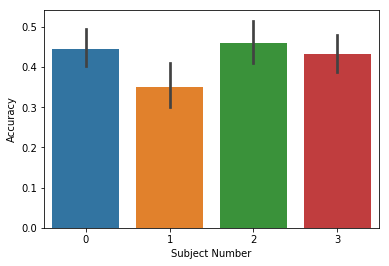

In [111]:
ax = q.plot(recall_accuracy, plot_type='subject', subjname='Subject Number')

## Serial Position Curves

So are serial position curves!!

In [112]:
spc = q.analyze(egg, analysis='spc', listgroup=['2']*8+['8']*8)
spc.head()

0      1      2      3      4      5      6      7      8   \
Subject List                                                                  
0       8     0.500  0.500  0.500  0.125  0.250  0.125  0.375  0.250  0.375   
        2     0.375  0.125  0.375  0.375  0.375  0.125  0.375  0.375  0.500   
1       8     0.750  0.625  0.625  0.250  0.250  0.125  0.500  0.500  0.250   
        2     0.875  0.875  0.500  0.125  0.250  0.375  0.125  0.250  0.250   
2       8     1.000  0.750  0.625  0.375  0.375  0.375  0.000  0.250  0.250   

                 9      10     11     12     13     14     15  
Subject List                                                   
0       8     0.250  0.250  0.750  0.500  0.750  0.875  0.875  
        2     0.500  0.750  0.375  0.500  0.625  0.500  0.750  
1       8     0.125  0.250  0.125  0.250  0.125  0.375  0.500  
        2     0.250  0.125  0.125  0.250  0.500  0.000  0.750  
2       8     0.125  0.375  0.250  0.625  0.125  0.375  1.000

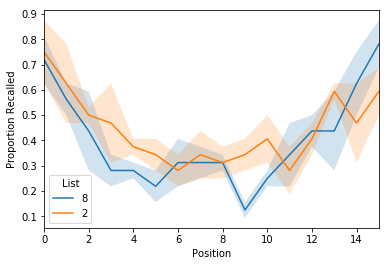

In [113]:
ax = q.plot(spc)

## Probability of First Recall

And wouldn't ya know, calculating the probability of first recall is also a breeze!

In [114]:
pfr = q.analyze(egg, analysis='pfr', listgroup=['2']*8+['8']*8)
pfr.head()

0      1    2    3      4    5     6      7    8    9      10  \
Subject List                                                                    
0       8     0.00  0.000  0.0  0.0  0.000  0.0  0.00  0.000  0.0  0.0  0.125   
        2     0.00  0.000  0.0  0.0  0.000  0.0  0.00  0.125  0.0  0.0  0.125   
1       8     0.50  0.125  0.0  0.0  0.125  0.0  0.25  0.000  0.0  0.0  0.000   
        2     0.75  0.125  0.0  0.0  0.000  0.0  0.00  0.000  0.0  0.0  0.000   
2       8     0.00  0.000  0.0  0.0  0.000  0.0  0.00  0.000  0.0  0.0  0.000   

                11   12     13     14     15  
Subject List                                  
0       8     0.25  0.0  0.250  0.125  0.250  
        2     0.00  0.0  0.125  0.000  0.625  
1       8     0.00  0.0  0.000  0.000  0.000  
        2     0.00  0.0  0.125  0.000  0.000  
2       8     0.00  0.0  0.000  0.000  1.000

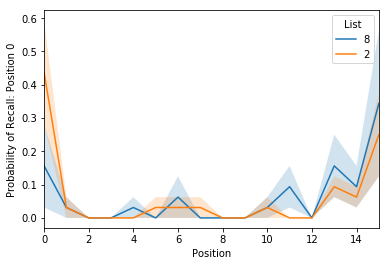

In [115]:
ax = q.plot(pfr)

## Lag-CRP

So, its really that easy isn't it? Just call the same three commands as before and change one of the input arguments? Yup!!

In [116]:
lagcrp = q.analyze(egg, analysis='lagcrp', listgroup=['2']*8+['8']*8)
lagcrp.head()

-16    -15    -14       -13  -12     -11      -10     -9   \
Subject List                                                              
0       8     0.0  0.125  0.125  0.000000  0.0  0.0000  0.03125  0.0625   
        2     0.0  0.125  0.000  0.041667  0.0  0.1875  0.03125  0.0000   
1       8     0.0  0.000  0.000  0.250000  0.0  0.0000  0.00000  0.0000   
        2     0.0  0.000  0.000  0.000000  0.0  0.1250  0.00000  0.1250   
2       8     0.0  0.375  0.125  0.000000  0.0  0.0000  0.06250  0.0000   

                   -8        -7  ...         7         8        9         10  \
Subject List                     ...                                           
0       8     0.000000  0.104167 ...   0.072917  0.125000  0.12500  0.000000   
        2     0.041667  0.025000 ...   0.125000  0.000000  0.18750  0.000000   
1       8     0.000000  0.104167 ...   0.062500  0.020833  0.03125  0.000000   
        2     0.145833  0.000000 ...   0.000000  0.041667  0.03125  0.072917   
2       8     0.062500  0.125000 ...   0.108333  0.072917  0.06250  0.000000   

               11       12        13     14     15   16  
Subject List                                             
0       8     0.0  0.00000  0.000000  0.000  0.000  0.0  
        2     0.0  0.00000  0.125000  0.000  0.000  0.0  
1       8     0.0  0.00000  0.000000  0.125  0.125  0.0  
        2     0.0  0.03125  0.041667  0.125  0.000  0.0  
2       8     0.0  0.00000  0.000000  0.000  0.000  0.0  

[5 rows x 33 columns]

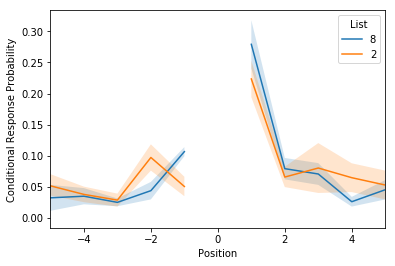

In [117]:
ax = q.plot(lagcrp)

## Temporal clustering

This analysis has got to be more difficult to do, right? Nope!

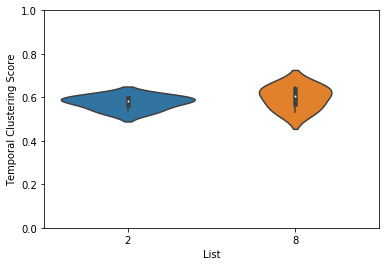

In [118]:
temporal = q.analyze(egg, analysis='temporal', listgroup=['2']*8+['8']*8)
ax = q.plot(temporal, plot_style='violin', ylim=[0,1])

In [119]:
# repeated measures ttest
t, p = stats.ttest_rel(temporal.xs('2', level='List'), temporal.xs('8', level='List'), nan_policy='omit')

# t and p values
print('Two Sided, repeated measures t-test of List(2/8):')
print('t-value: ' + str(t[0]))
print('p-value: ' + str(p[0]))

Two Sided, repeated measures t-test of List(2/8):
t-value: -0.738749341353
p-value: 0.513607248436


## Memory Fingerprint

Now, for the real fun stuff!

In [120]:
fingerprint = q.analyze(egg, analysis='fingerprint', listgroup=['2']*8+['8']*8)
fingerprint.head()

EmotionCategory
Subject List                 
0       8            0.512806
        2            0.553058
1       8            0.548263
        2            0.529050
2       8            0.486165

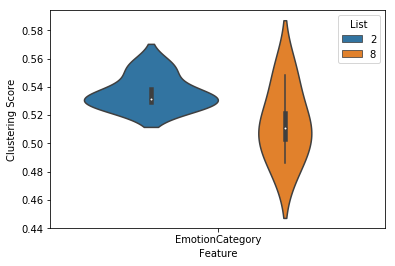

In [121]:
ax = q.plot(fingerprint)

In [122]:
# print the entire fingerprint dataframe. note the NaN.
print(fingerprint)

# repeated measures ttest
t, p = stats.ttest_rel(fingerprint.xs('2', level='List'), fingerprint.xs('8', level='List'), nan_policy='omit')

# t and p values
print('Two Sided, repeated measures t-test of List(2/8):')
print('t: ' + str(t[0]))
print('p: ' + str(p))

              EmotionCategory
Subject List                 
0       8            0.512806
        2            0.553058
1       8            0.548263
        2            0.529050
2       8            0.486165
        2            0.529062
3       8            0.509225
        2            0.533353
Two Sided, repeated measures t-test of List(2/8):
t: 1.53364907099
p: [ 0.22266042]
